# Import required packages

In [2]:
import numpy as np
import random
from scipy import stats
from smt.sampling_methods import LHS as LHS_sampling
import sklearn.preprocessing
from lib import MultiIndex, MPJacn, krr_helpers, JNodeWt
import spgl1

import torch
import pyro
import pyro.contrib.gp as gp

from scipy.special import eval_legendre, factorial
import matplotlib.pyplot as plt

# Import LaTeX
from matplotlib import rc
rc('text', usetex=True)
plt.rc('axes', labelsize=25)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r"\usepackage{amsmath} \usepackage{amssymb}"
plt.rcParams['font.family'] = 'Latin Modern Roman'

In [3]:
def LegendrePoly(x, order):
    norm = np.sqrt(2 / (2*order + 1))
    legendre_poly = eval_legendre(order, x)/norm
    return legendre_poly

def ProdLegendrePoly(x, indx):
    N_LD, dimension = np.shape(x)
    prod = np.ones((N_LD, 1))
    for dim in range(dimension):
        legendre_poly = LegendrePoly(x[:, dim], indx[dim])
        prod = prod*legendre_poly.reshape((-1, 1))
    return prod

def compute_ρ_torch_pyro(_xobs, _F, Pif, Pic, _nugget, _kernel):
    # Xf points
    Kf = _kernel.forward(_xobs[Pif, :]) + _nugget*torch.eye(sum(Pif))
    _Ff = _F[Pif]

    # Xc points
    Kc = _kernel.forward(_xobs[Pic, :]) + _nugget*torch.eye(sum(Pic))
    _Fc = _F[Pic]

    # Compute rho
    den = (_Fc.T @ torch.linalg.solve(Kc, _Fc))
    num = (_Ff.T @ torch.linalg.solve(Kf, _Ff))
    rho = 1 - den / num
    if rho < 0 or rho > 1:
        raise ValueError(f"Error in rho: {rho}")
    return rho

def compute_RMS_from_data(_x):
    """
    Compute the root mean square distance from a set of positions.
    """
    squared_distance = []
    try: # d-dimension
        n_obs, dimension = np.shape(_x)
        for i in range(n_obs):
            for j in range(i+1, n_obs):
                dist = 0
                for dim in range(dimension):
                    dist = dist + (_x[i, dim] - _x[j, dim])**2
                squared_distance.append(dist)

        RMS = np.sqrt( (2 / (n_obs * (n_obs-1)))*np.sum(squared_distance) )
        print("RMS computed from {} observations of dimension {}: {}".format(n_obs, dimension, RMS))
        return RMS
    except: # 1-dimension
        n_obs = np.size(_x)
        dimension = 1
        for i in range(n_obs):
            for j in range(i+1, n_obs):
                dist = 0
                dist = dist + (_x[i] - _x[j])**2
                squared_distance.append(dist)

        RMS = np.sqrt( (2 / (n_obs * (n_obs-1)))*np.sum(squared_distance) )
        print("RMS computed from {} observations of dimension {}: {}".format(n_obs, dimension, RMS))
        return RMS

def create_pif_pic(num_obs, Nf, Nc, seed = None):
    if seed != None:
        rng = np.random.default_rng(seed)
    else:
        rng = np.random.default_rng()

    # Pif points
    Pitot = np.full((num_obs), False)
    Pitot[:Nf] = True
    rng.shuffle(Pitot)
    Pif = Pitot

    # Pic points
    Pitot = np.full((num_obs), False)
    Pitot[rng.choice(np.where(Pif == True)[0], size = Nc, replace = False)] = True
    Pic = Pitot

    return Pif, Pic

# Ishigami test case

## Ishigami function parameters

In [9]:
def FGT(_x, a, b):
    x, y, z = _x[:, 0], _x[:, 1], _x[:, 2]
    out = np.sin(x) + a*(np.sin(y))**2 + b*((z)**4)*np.sin(x)
    return out

performance_func = "Ishigami_3D"
a, b = 7, 0.1
analytical_mean = a*0.5
analytical_variance = 0.5 + a**2/8 + b**(2)*np.pi**(8)/18 + b*np.pi**(4)/5

# Parameters of the study
number_of_seeds = 10
number_of_observations_LD_list = [100]

# Bounds of the input space
bounds = np.array([[-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi]])
# Scaling the inputs
scaler = sklearn.preprocessing.MinMaxScaler((-1, 1))
scaler.fit(bounds.T)

dimension = 3

## Surrogate modeling methods

### SSKRR Algorithm and sparse gPC

In [ ]:
# Some useful parameters
nuggets = 10**(np.linspace(np.log10(1e-12), np.log10(1e0), num = 31))

# Save the predictions on the test dataset
Y_SSKRR_TD_list = []
Y_PCE_TD_list = []
Y_TD_list = []

# Total order of the basis
total_order = 10

# Compute the corresponding indexes
indexes, _ = MultiIndex.MultiIndex(total_order, dimension)

# Corresponds to uniform distribution
alpha = [0]*dimension; beta = [0]*dimension

for number_of_observations_LD in number_of_observations_LD_list:
    for current_seed in range(number_of_seeds):
        print(f"Current seed: {current_seed}")
        seed = current_seed
        number_of_observations = number_of_observations_LD

        # Define the learning set
        # Number of observatitons of the learning set
        N_LD = number_of_observations

        # Sampling the learning set
        sampling = LHS_sampling(xlimits = bounds, criterion = "maximin", random_state = seed)
        X_LD = sampling(N_LD)
        X_LD_scaled = scaler.transform(X_LD)
        Y_LD = FGT(X_LD, a, b)

        kappa_var = np.var(Y_LD)

        # SPGL1 Optimization
        # min |c|_L1 s. t. ||Tc - b||_2 <= epsilon

        print(f"Compute theta for SPGL1 using PCE with total order {total_order} corresponding to {len(indexes)} expansion coefficients")
        theta = np.zeros((N_LD, len(indexes)))
        for obs in range(N_LD):
            theta[obs, :] = MPJacn.MPJacn(X_LD_scaled[obs, :], total_order, alpha, beta, indexes)

        # Convergence criterion for SPGL1
        sigma = 1e-6
        opt_tol = 1e-8

        # SPGL1 solver
        c, resid, grad, info = spgl1.spg_bpdn(theta, np.reshape(Y_LD, (-1,)), sigma, verbosity=3, iter_lim = int(1e5), opt_tol = opt_tol)

        # Plot the SPGL1 solution of the expansion coefficients
        plt.figure()
        plt.plot(abs(c), 'or', markersize=3, mec='k', mew = 0.5)
        plt.xlabel(r"i--th Legendre polynomial"); plt.ylabel(r"$|c_i|$")
        plt.grid(True, color = "black", which="major", ls="--", linewidth = 0.25)
        plt.grid(True, color = "gray", which="minor", ls="--", linewidth = 0.25)
        plt.show()
        plt.close('all')

        plt.figure()
        plt.plot(abs(c), 'or', markersize=3, mec='k', mew = 0.5)
        plt.yscale('log')
        plt.xlabel(r"i--th Legendre polynomial"); plt.ylabel(r"$|c_i|$")
        plt.grid(True, color = "black", which="major", ls="--", linewidth = 0.25)
        plt.grid(True, color = "gray", which="minor", ls="--", linewidth = 0.25)
        plt.show()
        plt.close('all')

        # c_k values and number of basis functions
        ck_value, R_S = c, np.shape(c)[0]

        # Matrix corresponding to the values of the basis at the observations
        e_sparse = theta

        # PCE
        # Norm for moment order of PCE
        norm_moment_order = 1
        for dim in range(dimension):
            norm_moment_order = norm_moment_order*(2**(alpha[dim]+beta[dim]+1)*factorial(alpha[dim])*factorial(beta[dim])/factorial(alpha[dim]+beta[dim]+1))
        norm_moment_order = np.sqrt(norm_moment_order)

        # Mean using PCE
        mean_PCE = ck_value[0] / norm_moment_order
        # Variance using PCE
        var_PCE = np.sum(ck_value[1:]**2) / norm_moment_order**2

        # SSKRR Algorithm
        # Minimize the eigenvalues
        sigma_min = []
        for k in range(R_S):
            num = np.abs(ck_value[k])
            den = np.sum(np.abs(ck_value))
            sigma_temp = kappa_var*(num/den)
            sigma_min.append(sigma_temp)

        sigma_min = np.array(sigma_min).reshape((-1,))

        # Test dataset
        # Compute the error over test_sampling using N_TD sampling
        N_TD = int(1e5)
        np.random.seed(seed)
        X_TD_scaled = np.random.uniform(-1, 1, size=(N_TD, dimension))
        X_TD = scaler.inverse_transform(X_TD_scaled)
        Y_TD = FGT(X_TD, a, b)
        Y_TD_list.append(Y_TD)

        # Compute PCE in the test dataset
        e_PCE = np.zeros((N_TD, R_S))
        for idx in range(R_S):
            e_PCE[:, idx] = ProdLegendrePoly(X_TD_scaled, indexes[idx]).reshape((-1, ))
        Y_PCE = e_PCE @ np.array(ck_value)
        Y_PCE_TD_list.append(Y_PCE)

        RMSE_gPC = np.sqrt(np.mean((Y_PCE - Y_TD)**2))

        # Find the best value of the nugget through grid search
        RMSE_optm_list = []
        for nugget in nuggets:
            # Prediction mean of the GP using the kernel given by the SSKRR algorithm
            K_OBS = e_sparse @ np.diag(sigma_min) @ e_sparse.T
            K_OBS = K_OBS + nugget*np.eye(N_LD)
            K_PREDICT = e_PCE @ np.diag(sigma_min) @ e_sparse.T
            Y_predict_optm = K_PREDICT @ np.linalg.solve(K_OBS, Y_LD)

            # Save the current RMSE on the test set
            RMSE_optm_list.append(np.sqrt(np.mean((Y_TD - Y_predict_optm)**2)))

            # Only keep the best kernel
            if (len(RMSE_optm_list) == 1) or (RMSE_optm_list[-1] < np.min(RMSE_optm_list[:-1])):
                # Value of the minimum of the RMSE
                min_RMSE_SSKRR = RMSE_optm_list[-1]

                # Kappa corresponding to the minimum of the RMSE
                min_nugget = nugget

                # Best prediction corresponding to the minimum of the RMSE
                Y_best_predict_optm = Y_predict_optm

        Y_SSKRR_TD_list.append(Y_best_predict_optm)

        print(f"Log10(RMSE) with SSKRR algorithm: {np.log10(min_RMSE_SSKRR)}")
        print(f"Log10(RMSE) with gPC: {np.log10(RMSE_gPC)}")

### Gaussion process regression surrogate using Gaussian kernel

RMS computed from 100 observations of dimension 1: 0.8203992120805557
RMS computed from 100 observations of dimension 1: 0.8216724552683968
RMS computed from 100 observations of dimension 1: 0.820900036330632
1.4581039711263155


C:\Users\Luc\AppData\Local\Temp\ipykernel_15612\2016414640.py:29: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:3281.)
  den = (_Fc.T @ torch.linalg.solve(Kc, _Fc))
c:\Users\Luc\AppData\Local\Programs\Python\Python38\lib\site-packages\pyro\contrib\gp\models\gpr.py:126: UserWarning: torch.cholesky is deprecated in favor of torch.linalg.cholesky and will be removed in a future PyTorch release.
L = torch.cholesky(A)
should be replaced with
L = torch.linalg.cholesky(A)
and
U = torch.cholesky(A, upper=True)
should be replaced with
U = torch.linalg.cholesky(A).mH().
This transform will produce equivalent results for all valid (s

ρ_optm: [tensor(0.7837, dtype=torch.float64, grad_fn=<RsubBackward1>)]
Learning: Iteration n. 100 / 2000
tensor([0.5686, 0.5640, 0.5902], dtype=torch.float64)
Learning: Iteration n. 200 / 2000
tensor([0.5566, 0.5475, 0.6029], dtype=torch.float64)
Learning: Iteration n. 300 / 2000
tensor([0.5477, 0.5318, 0.6130], dtype=torch.float64)
Learning: Iteration n. 400 / 2000
tensor([0.5337, 0.5178, 0.6158], dtype=torch.float64)
Learning: Iteration n. 500 / 2000
tensor([0.5245, 0.5043, 0.6180], dtype=torch.float64)
Learning: Iteration n. 600 / 2000
tensor([0.5140, 0.4918, 0.6138], dtype=torch.float64)
Learning: Iteration n. 700 / 2000
tensor([0.5044, 0.4799, 0.6068], dtype=torch.float64)
Learning: Iteration n. 800 / 2000
tensor([0.4918, 0.4691, 0.5952], dtype=torch.float64)
Learning: Iteration n. 900 / 2000
tensor([0.4806, 0.4586, 0.5799], dtype=torch.float64)
Learning: Iteration n. 1000 / 2000
tensor([0.4704, 0.4487, 0.5649], dtype=torch.float64)
Learning: Iteration n. 1100 / 2000
tensor([0.460

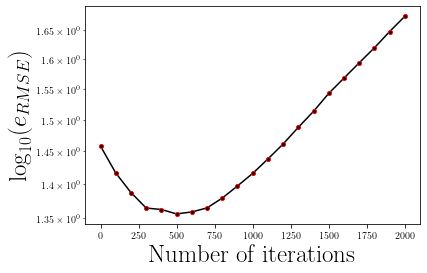

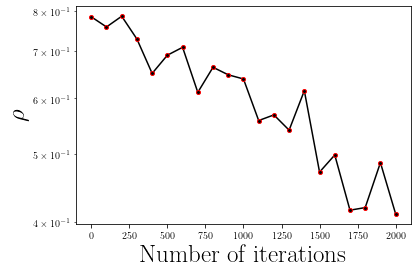

C:\Users\Luc\AppData\Local\Temp\ipykernel_15612\846518375.py:119: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


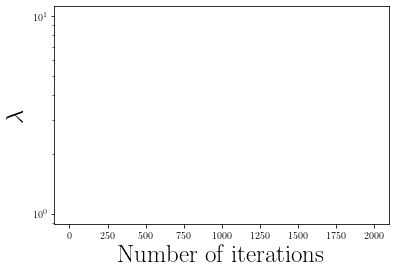

Log10(RMSE): 0.13235091189133846
RMS computed from 100 observations of dimension 1: 0.8203516924062288
RMS computed from 100 observations of dimension 1: 0.8198237862076061
RMS computed from 100 observations of dimension 1: 0.8213352534425921
1.4394191596749542
ρ_optm: [tensor(0.7566, dtype=torch.float64, grad_fn=<RsubBackward1>)]
Learning: Iteration n. 100 / 2000
tensor([0.5883, 0.5626, 0.5881], dtype=torch.float64)
Learning: Iteration n. 200 / 2000
tensor([0.5931, 0.5460, 0.5951], dtype=torch.float64)
Learning: Iteration n. 300 / 2000
tensor([0.5977, 0.5303, 0.6018], dtype=torch.float64)
Learning: Iteration n. 400 / 2000
tensor([0.5997, 0.5160, 0.6047], dtype=torch.float64)
Learning: Iteration n. 500 / 2000
tensor([0.5939, 0.5031, 0.6006], dtype=torch.float64)
Learning: Iteration n. 600 / 2000
tensor([0.5891, 0.4915, 0.5921], dtype=torch.float64)
Learning: Iteration n. 700 / 2000
tensor([0.5806, 0.4804, 0.5798], dtype=torch.float64)
Learning: Iteration n. 800 / 2000
tensor([0.5712, 0

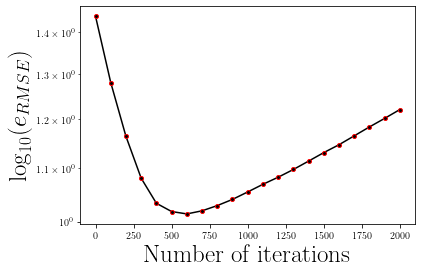

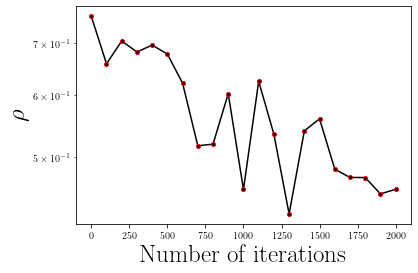

C:\Users\Luc\AppData\Local\Temp\ipykernel_15612\846518375.py:119: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


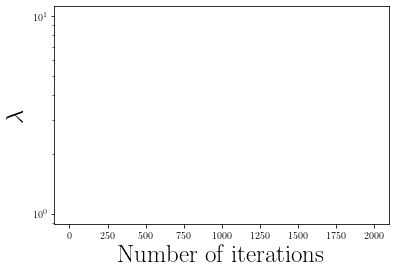

Log10(RMSE): 0.006315162821932395
RMS computed from 100 observations of dimension 1: 0.8200504376577242
RMS computed from 100 observations of dimension 1: 0.8207610305278594
RMS computed from 100 observations of dimension 1: 0.820895166535153
1.4667884318367423
ρ_optm: [tensor(0.7396, dtype=torch.float64, grad_fn=<RsubBackward1>)]
Learning: Iteration n. 100 / 2000
tensor([0.5796, 0.5639, 0.5766], dtype=torch.float64)
Learning: Iteration n. 200 / 2000
tensor([0.5822, 0.5479, 0.5700], dtype=torch.float64)
Learning: Iteration n. 300 / 2000
tensor([0.5847, 0.5324, 0.5649], dtype=torch.float64)
Learning: Iteration n. 400 / 2000
tensor([0.5860, 0.5180, 0.5570], dtype=torch.float64)
Learning: Iteration n. 500 / 2000
tensor([0.5874, 0.5050, 0.5454], dtype=torch.float64)
Learning: Iteration n. 600 / 2000
tensor([0.5832, 0.4929, 0.5330], dtype=torch.float64)
Learning: Iteration n. 700 / 2000
tensor([0.5791, 0.4817, 0.5219], dtype=torch.float64)
Learning: Iteration n. 800 / 2000
tensor([0.5740, 0

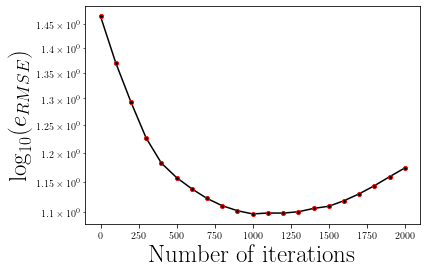

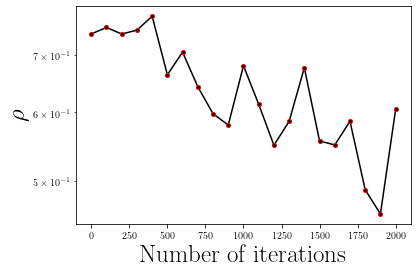

C:\Users\Luc\AppData\Local\Temp\ipykernel_15612\846518375.py:119: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


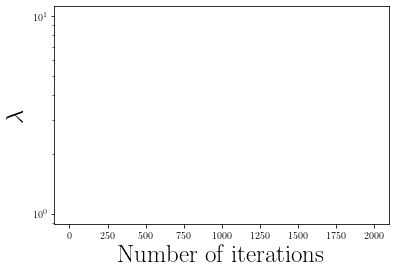

Log10(RMSE): 0.04029661050949837
RMS computed from 100 observations of dimension 1: 0.8204914206112055
RMS computed from 100 observations of dimension 1: 0.8201367430008112
RMS computed from 100 observations of dimension 1: 0.8215931728118944
1.782568363792184
ρ_optm: [tensor(0.7511, dtype=torch.float64, grad_fn=<RsubBackward1>)]
Learning: Iteration n. 100 / 2000
tensor([0.5670, 0.5630, 0.5831], dtype=torch.float64)
Learning: Iteration n. 200 / 2000
tensor([0.5558, 0.5463, 0.5860], dtype=torch.float64)
Learning: Iteration n. 300 / 2000
tensor([0.5455, 0.5304, 0.5847], dtype=torch.float64)
Learning: Iteration n. 400 / 2000
tensor([0.5371, 0.5154, 0.5798], dtype=torch.float64)
Learning: Iteration n. 500 / 2000
tensor([0.5256, 0.5016, 0.5713], dtype=torch.float64)
Learning: Iteration n. 600 / 2000
tensor([0.5141, 0.4888, 0.5590], dtype=torch.float64)
Learning: Iteration n. 700 / 2000
tensor([0.5059, 0.4758, 0.5518], dtype=torch.float64)
Learning: Iteration n. 800 / 2000
tensor([0.4984, 0.

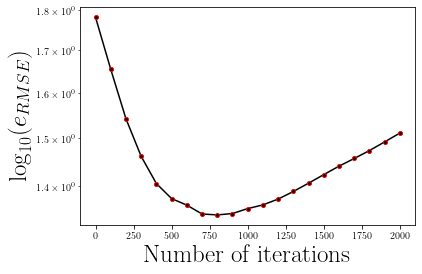

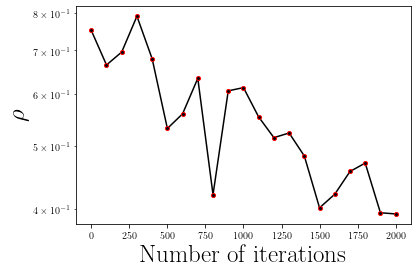

C:\Users\Luc\AppData\Local\Temp\ipykernel_15612\846518375.py:119: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


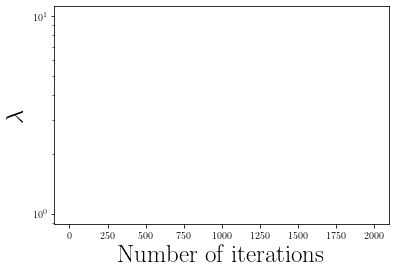

Log10(RMSE): 0.12851057902032476
RMS computed from 100 observations of dimension 1: 0.820431301509657
RMS computed from 100 observations of dimension 1: 0.8198981548028199
RMS computed from 100 observations of dimension 1: 0.8212948123940966
1.9212467440951602
ρ_optm: [tensor(0.7456, dtype=torch.float64, grad_fn=<RsubBackward1>)]
Learning: Iteration n. 100 / 2000
tensor([0.5660, 0.5632, 0.5663], dtype=torch.float64)
Learning: Iteration n. 200 / 2000
tensor([0.5500, 0.5481, 0.5521], dtype=torch.float64)
Learning: Iteration n. 300 / 2000
tensor([0.5363, 0.5327, 0.5384], dtype=torch.float64)
Learning: Iteration n. 400 / 2000
tensor([0.5229, 0.5180, 0.5247], dtype=torch.float64)
Learning: Iteration n. 500 / 2000
tensor([0.5120, 0.5029, 0.5139], dtype=torch.float64)
Learning: Iteration n. 600 / 2000
tensor([0.5005, 0.4895, 0.5033], dtype=torch.float64)
Learning: Iteration n. 700 / 2000
tensor([0.4881, 0.4767, 0.4928], dtype=torch.float64)
Learning: Iteration n. 800 / 2000
tensor([0.4778, 0.

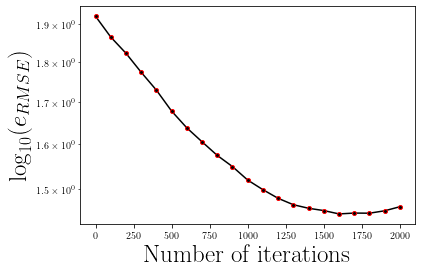

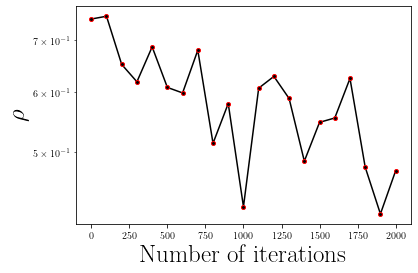

C:\Users\Luc\AppData\Local\Temp\ipykernel_15612\846518375.py:119: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


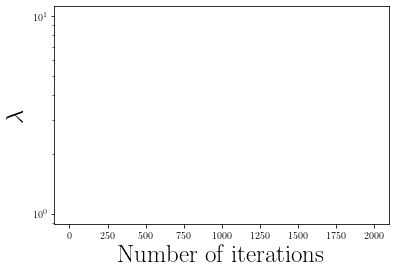

Log10(RMSE): 0.16055374146715468
RMS computed from 100 observations of dimension 1: 0.8211948402509751
RMS computed from 100 observations of dimension 1: 0.8217320672116452
RMS computed from 100 observations of dimension 1: 0.8202913968783758
1.7658850485288862
ρ_optm: [tensor(0.7060, dtype=torch.float64, grad_fn=<RsubBackward1>)]
Learning: Iteration n. 100 / 2000
tensor([0.5663, 0.5646, 0.5686], dtype=torch.float64)
Learning: Iteration n. 200 / 2000
tensor([0.5550, 0.5493, 0.5559], dtype=torch.float64)
Learning: Iteration n. 300 / 2000
tensor([0.5422, 0.5351, 0.5436], dtype=torch.float64)
Learning: Iteration n. 400 / 2000
tensor([0.5316, 0.5209, 0.5316], dtype=torch.float64)
Learning: Iteration n. 500 / 2000
tensor([0.5220, 0.5065, 0.5200], dtype=torch.float64)
Learning: Iteration n. 600 / 2000
tensor([0.5116, 0.4940, 0.5101], dtype=torch.float64)
Learning: Iteration n. 700 / 2000
tensor([0.5018, 0.4832, 0.4993], dtype=torch.float64)
Learning: Iteration n. 800 / 2000
tensor([0.4938, 0

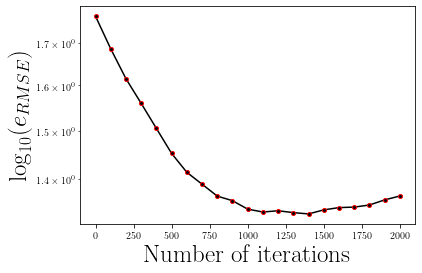

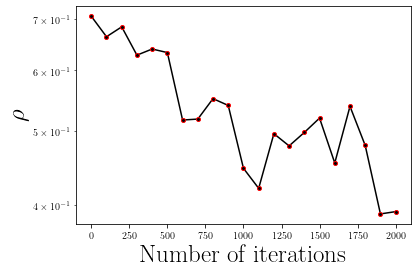

C:\Users\Luc\AppData\Local\Temp\ipykernel_15612\846518375.py:119: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


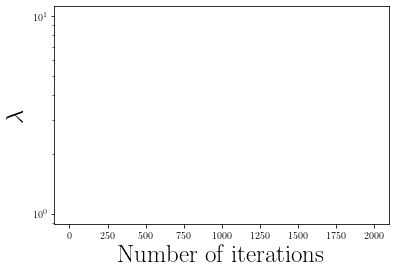

Log10(RMSE): 0.1245438281925645
RMS computed from 100 observations of dimension 1: 0.8208736612709434
RMS computed from 100 observations of dimension 1: 0.8199614499077909
RMS computed from 100 observations of dimension 1: 0.8205569784068857
1.621450567618965
ρ_optm: [tensor(0.7184, dtype=torch.float64, grad_fn=<RsubBackward1>)]
Learning: Iteration n. 100 / 2000
tensor([0.5919, 0.5626, 0.5640], dtype=torch.float64)
Learning: Iteration n. 200 / 2000
tensor([0.6065, 0.5452, 0.5492], dtype=torch.float64)
Learning: Iteration n. 300 / 2000
tensor([0.6147, 0.5296, 0.5350], dtype=torch.float64)
Learning: Iteration n. 400 / 2000
tensor([0.6216, 0.5139, 0.5228], dtype=torch.float64)
Learning: Iteration n. 500 / 2000
tensor([0.6240, 0.5000, 0.5106], dtype=torch.float64)
Learning: Iteration n. 600 / 2000
tensor([0.6234, 0.4873, 0.4970], dtype=torch.float64)
Learning: Iteration n. 700 / 2000
tensor([0.6201, 0.4758, 0.4831], dtype=torch.float64)
Learning: Iteration n. 800 / 2000
tensor([0.6134, 0.4

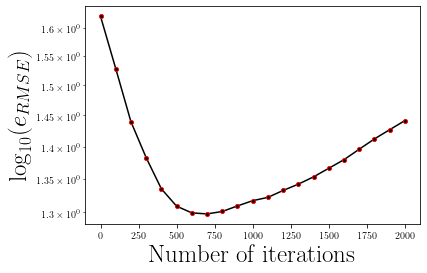

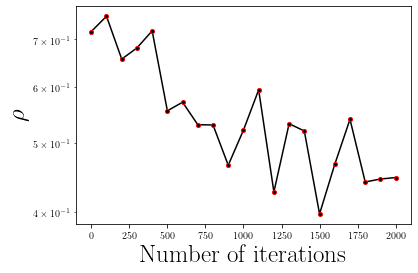

C:\Users\Luc\AppData\Local\Temp\ipykernel_15612\846518375.py:119: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


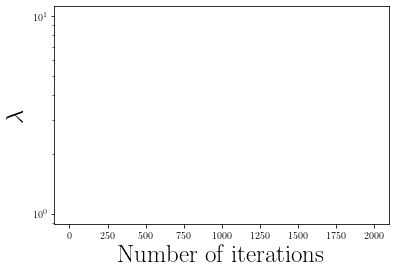

Log10(RMSE): 0.1131757925792423
RMS computed from 100 observations of dimension 1: 0.8204351807859291
RMS computed from 100 observations of dimension 1: 0.8203141799728475
RMS computed from 100 observations of dimension 1: 0.81976037046289
1.593776509591604
ρ_optm: [tensor(0.7280, dtype=torch.float64, grad_fn=<RsubBackward1>)]
Learning: Iteration n. 100 / 2000
tensor([0.5658, 0.5633, 0.5729], dtype=torch.float64)
Learning: Iteration n. 200 / 2000
tensor([0.5532, 0.5471, 0.5672], dtype=torch.float64)
Learning: Iteration n. 300 / 2000
tensor([0.5416, 0.5309, 0.5617], dtype=torch.float64)
Learning: Iteration n. 400 / 2000
tensor([0.5293, 0.5166, 0.5513], dtype=torch.float64)
Learning: Iteration n. 500 / 2000
tensor([0.5176, 0.5026, 0.5398], dtype=torch.float64)
Learning: Iteration n. 600 / 2000
tensor([0.5052, 0.4894, 0.5296], dtype=torch.float64)
Learning: Iteration n. 700 / 2000
tensor([0.4955, 0.4764, 0.5181], dtype=torch.float64)
Learning: Iteration n. 800 / 2000
tensor([0.4863, 0.464

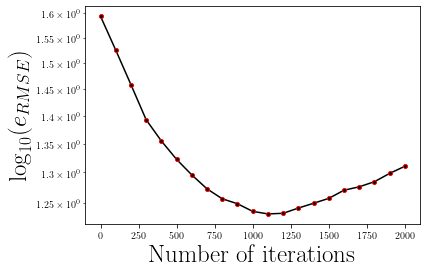

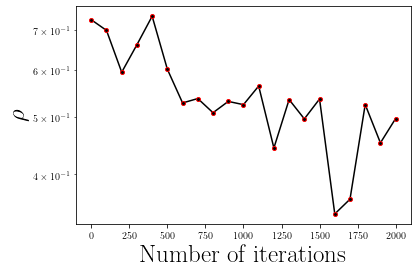

C:\Users\Luc\AppData\Local\Temp\ipykernel_15612\846518375.py:119: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


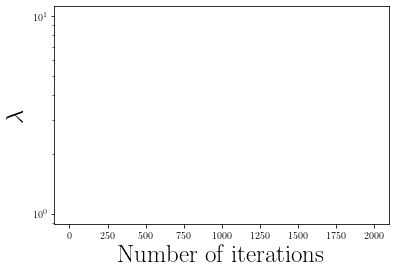

Log10(RMSE): 0.09048429217171249
RMS computed from 100 observations of dimension 1: 0.8208162629268189
RMS computed from 100 observations of dimension 1: 0.8203367334317098
RMS computed from 100 observations of dimension 1: 0.8212885114563551
1.6881273078808419
ρ_optm: [tensor(0.7662, dtype=torch.float64, grad_fn=<RsubBackward1>)]
Learning: Iteration n. 100 / 2000
tensor([0.5699, 0.5643, 0.5665], dtype=torch.float64)
Learning: Iteration n. 200 / 2000
tensor([0.5578, 0.5485, 0.5534], dtype=torch.float64)
Learning: Iteration n. 300 / 2000
tensor([0.5473, 0.5333, 0.5399], dtype=torch.float64)
Learning: Iteration n. 400 / 2000
tensor([0.5378, 0.5186, 0.5266], dtype=torch.float64)
Learning: Iteration n. 500 / 2000
tensor([0.5276, 0.5047, 0.5137], dtype=torch.float64)
Learning: Iteration n. 600 / 2000
tensor([0.5196, 0.4914, 0.5006], dtype=torch.float64)
Learning: Iteration n. 700 / 2000
tensor([0.5101, 0.4791, 0.4882], dtype=torch.float64)
Learning: Iteration n. 800 / 2000
tensor([0.5022, 0

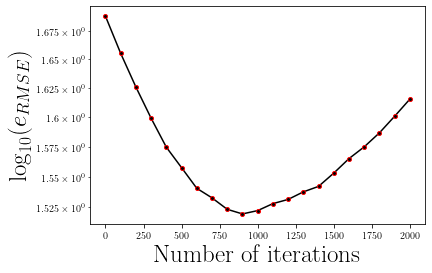

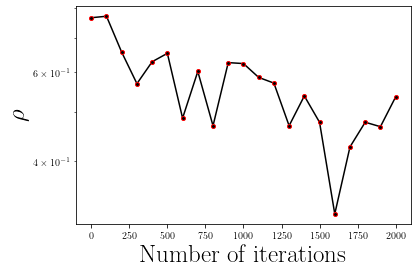

C:\Users\Luc\AppData\Local\Temp\ipykernel_15612\846518375.py:119: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


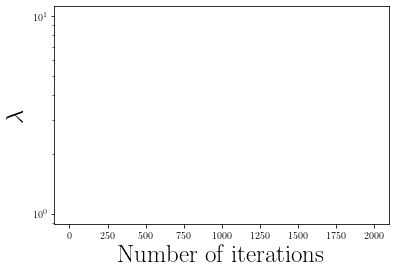

Log10(RMSE): 0.18170017685027598
RMS computed from 100 observations of dimension 1: 0.8209172417731992
RMS computed from 100 observations of dimension 1: 0.8198633434687825
RMS computed from 100 observations of dimension 1: 0.8224114442078336
1.521877997171978
ρ_optm: [tensor(0.6989, dtype=torch.float64, grad_fn=<RsubBackward1>)]
Learning: Iteration n. 100 / 2000
tensor([0.5889, 0.5630, 0.5887], dtype=torch.float64)
Learning: Iteration n. 200 / 2000
tensor([0.6001, 0.5466, 0.5924], dtype=torch.float64)
Learning: Iteration n. 300 / 2000
tensor([0.6046, 0.5316, 0.5965], dtype=torch.float64)
Learning: Iteration n. 400 / 2000
tensor([0.6077, 0.5183, 0.5917], dtype=torch.float64)
Learning: Iteration n. 500 / 2000
tensor([0.6024, 0.5059, 0.5822], dtype=torch.float64)
Learning: Iteration n. 600 / 2000
tensor([0.5954, 0.4943, 0.5697], dtype=torch.float64)
Learning: Iteration n. 700 / 2000
tensor([0.5855, 0.4832, 0.5548], dtype=torch.float64)
Learning: Iteration n. 800 / 2000
tensor([0.5761, 0.

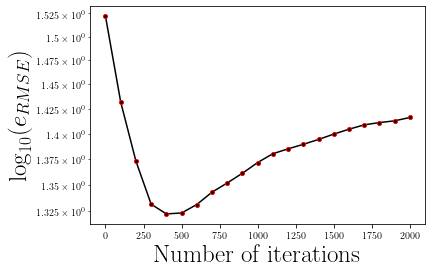

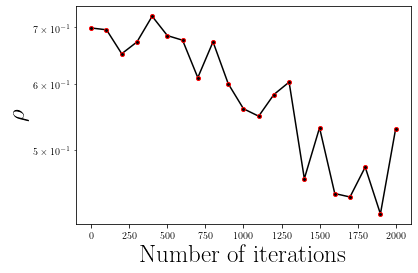

C:\Users\Luc\AppData\Local\Temp\ipykernel_15612\846518375.py:119: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale("log")


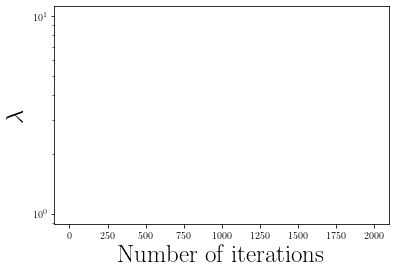

Log10(RMSE): 0.12128434336387522


In [8]:
init_nugget_kernel = 0
Y_GPR_list = []
for number_of_observations_LD in number_of_observations_LD_list:
    for current_seed in range(number_of_seeds):
        # Current seed for LHS
        seed = current_seed

        # Define the learning set
        # Number of observatitons of the learning set
        N_LD = number_of_observations_LD

        # Sampling the learning set
        sampling = LHS_sampling(xlimits = bounds, criterion = "maximin", random_state = seed)
        X_LD = sampling(N_LD)
        X_LD_scaled = scaler.transform(X_LD)
        Y_LD = FGT(X_LD, a, b)

        _, dimension = np.shape(X_LD)
        kappa_var = np.var(Y_LD)
        # Test dataset
        # Compute the error over test_sampling using N_TD sampling
        N_TD = int(1e5)
        np.random.seed(seed)
        X_TD_scaled = np.random.uniform(-1, 1, size=(N_TD, dimension))
        X_TD = scaler.inverse_transform(X_TD_scaled)
        Y_TD = FGT(X_TD, a, b)

        # Initial lengthscale
        # One lengthscale per input dimension
        gamma = []
        for d in range(dimension):
            temp = krr_helpers.compute_RMS_from_data(X_LD_scaled[:, d])/np.sqrt(2)
            gamma.append(temp)


        # GPR using pytorch
        Nf, Nc = (N_LD, int(N_LD/2))
        ite_max = int(2000)
        ite_save = int(100)

        # Pif and Pic
        Pif, Pic = krr_helpers.create_pif_pic(N_LD, Nf, Nc, seed = None)

        # Parameters of the algo
        variable_gamma = torch.tensor(gamma, requires_grad=True)
        nugget_optm = torch.tensor([init_nugget_kernel], requires_grad=False)
        nugget_optm_list = []
        nugget_optm_list.append(torch.clone(nugget_optm).detach().numpy())
        variable_gamma_optm = [torch.clone(variable_gamma).detach().numpy()]

        # Choice of the kernel
        kernel = gp.kernels.RBF(input_dim = dimension, variance=torch.tensor(1.), lengthscale=variable_gamma) # RBF

        # Compute the loss and choose the optimizer
        loss = compute_ρ_torch_pyro(torch.from_numpy(X_LD_scaled), torch.tensor(Y_LD), Pif, Pic, nugget_optm, kernel)
        optimizer = torch.optim.Adam([kernel.lengthscale_unconstrained, nugget_optm], lr = 3e-4)

        # Clear pyro parameters for new loop
        pyro.clear_param_store()

        # GPR Prediction
        gpr_opt = gp.models.GPRegression(torch.from_numpy(X_LD_scaled), torch.from_numpy(Y_LD), kernel, noise=torch.tensor(0.), jitter = nugget_optm)
        value_torch, _ = gpr_opt(torch.from_numpy(X_TD_scaled), full_cov=False, noiseless=True)
        value_torch = torch.clone(value_torch).detach().numpy()
        RMSE_torch = np.sqrt(np.mean((Y_TD - value_torch)**2))
        print(RMSE_torch)
        ρ_optm = [loss]
        print(f"ρ_optm: {ρ_optm}")
        ite_list = [0]
        RMSE_torch_list_temp = [RMSE_torch]
        for k in range(ite_max):
            optimizer.zero_grad()
            loss = compute_ρ_torch_pyro(torch.from_numpy(X_LD_scaled), torch.tensor(Y_LD), Pif, Pic, nugget_optm, kernel)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                kernel.lengthscale[:] = kernel.lengthscale.clamp(0, 1e6)
                nugget_optm[:] = nugget_optm.clamp(0, 1e6)
                if (k+1)%ite_save == 0:
                    print(f"Learning: Iteration n. {k+1} / {ite_max}")

                    # Print current length scales of the kernel
                    print(kernel.lengthscale)

                    # Store loss value and current optimized parameters
                    ρ_optm.append(loss.item())
                    ite_list.append((k+1))
                    variable_gamma_optm.append(torch.clone(kernel.lengthscale).detach().numpy())
                    nugget_optm_list.append(torch.clone(nugget_optm).detach().numpy())

                    # Compute the test error
                    gpr_opt = gp.models.GPRegression(torch.from_numpy(X_LD_scaled), torch.from_numpy(Y_LD), kernel, noise=torch.tensor(0.), jitter = nugget_optm)
                    value_torch, _ = gpr_opt(torch.from_numpy(X_TD_scaled), full_cov=False, noiseless=True)
                    value_torch = torch.clone(value_torch).detach().numpy()
                    RMSE_torch = np.sqrt(np.mean((Y_TD - value_torch)**2))
                    RMSE_torch_list_temp.append(RMSE_torch)

            # Update new batch
            Pif, Pic = krr_helpers.create_pif_pic(N_LD, Nf, Nc, seed = None)

        plt.figure()
        plt.plot(ite_list, RMSE_torch_list_temp, '-ok', markersize = 4, markeredgecolor = 'r', markeredgewidth = 1)
        plt.yscale("log")
        plt.xlabel(r"Number of iterations")
        plt.ylabel(r"$\log_{10}(e_{RMSE})$")
        plt.show()
        plt.close('all')

        plt.figure()
        plt.plot(ite_list, ρ_optm, '-ok', markersize = 4, markeredgecolor = 'r', markeredgewidth = 1)
        plt.yscale("log")
        plt.xlabel(r"Number of iterations")
        plt.ylabel(r"$\rho$")
        plt.show()
        plt.close('all')

        plt.figure()
        plt.plot(ite_list, nugget_optm_list, '-ok', markersize = 4, markeredgecolor = 'r', markeredgewidth = 1)
        plt.yscale("log")
        plt.xlabel(r"Number of iterations")
        plt.ylabel(r"$\lambda$")
        plt.show()
        plt.close('all')

        # Compute with the best hyperparameters on the test set
        idx_min_RMSE = np.argmin(RMSE_torch_list_temp)
        gamma_min = variable_gamma_optm[idx_min_RMSE]
        kernel_best = gp.kernels.RBF(input_dim = dimension, variance=torch.tensor(1.), lengthscale=torch.from_numpy(gamma_min)) # RBF
        gpr_opt_best = gp.models.GPRegression(torch.from_numpy(X_LD_scaled), torch.from_numpy(Y_LD), kernel_best, noise=torch.tensor(0.), jitter = nugget_optm)
        value_torch_best, _ = gpr_opt_best(torch.from_numpy(X_TD_scaled), full_cov=False, noiseless=True)
        value_torch_best = torch.clone(value_torch_best).detach().numpy()

        Y_GPR_list.append(value_torch_best)

        print(f"Log10(RMSE): {np.log10(RMSE_torch_list_temp[idx_min_RMSE])}")

### Fully tensorized gPC

Compute theta vector using PCE with total order 10 corresponding to 286 parameters


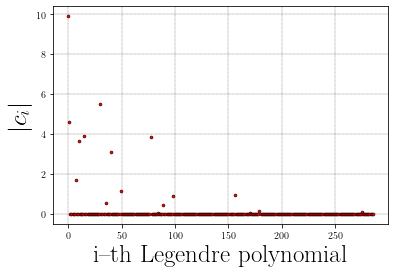

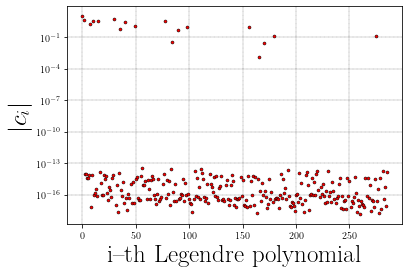

Log10(RMSE) with gPC: -2.1765270618656953
Log10(RMSE) with gPC: -2.1765985909638594
Log10(RMSE) with gPC: -2.1761406294167895
Log10(RMSE) with gPC: -2.1774621993707326
Log10(RMSE) with gPC: -2.1772470729676403
Log10(RMSE) with gPC: -2.1762076262264265
Log10(RMSE) with gPC: -2.1761412064231473
Log10(RMSE) with gPC: -2.1781372562134957
Log10(RMSE) with gPC: -2.1772710687040115
Log10(RMSE) with gPC: -2.1762841183945953


In [10]:
Y_FT_PCE_list = []

for number_of_observations_LD in number_of_observations_LD_list:
    # Define the learning set
    # Number of observatitons of the learning set
    N_LD = number_of_observations_LD

    # Bounds of the input space
    bounds = np.array([[-np.pi, np.pi], [-np.pi, np.pi], [-np.pi, np.pi]])
    scaler = sklearn.preprocessing.MinMaxScaler((-1, 1))
    scaler.fit(bounds.T)

    # Total order of the basis
    total_order = 10

    # Compute the corresponding indexes
    indexes, _ = MultiIndex.MultiIndex(total_order, dimension)

    # Corresponds to uniform distribution
    alpha = [0, 0, 0]; beta = [0, 0, 0]

    N_NODES = int(np.around((total_order*2 + 3) / 2))
    CHOICE_QUAD = 2 # Correspond to GJL quadrature
    N_LD = N_NODES**dimension
    X_LD_scaled = np.zeros((N_NODES**dimension, dimension))
    quad, weights = JNodeWt.JNodeWt(N_NODES-1, CHOICE_QUAD,0 ,0)
    multi_dim_weights = np.zeros((N_NODES**dimension, dimension))
    count = 0
    for i in range(N_NODES):
        for j in range(N_NODES):
            for k in range(N_NODES):
                X_LD_scaled[count, :] = quad[i], quad[j], quad[k]
                multi_dim_weights[count, :] = weights[i], weights[j], weights[k]
                count = count + 1
    prod_multi_dim_weights = np.prod(multi_dim_weights, axis = 1)
    diag_prod_multi_dim_weights = np.diag(prod_multi_dim_weights)
    X_LD = scaler.inverse_transform(X_LD_scaled)
    Y_LD = FGT(X_LD, a, b)

    indexes, _ = MultiIndex.MultiIndex(total_order, dimension)
    theta = np.zeros((N_LD, len(indexes)))
    alpha = [0, 0, 0]; beta = [0, 0, 0] # Corresponds to uniform distribution
    print(f"Compute theta vector using PCE with total order {total_order} corresponding to {len(indexes)} parameters")
    for obs in range(N_LD):
        theta[obs, :] = MPJacn.MPJacn(X_LD_scaled[obs, :], total_order, alpha, beta, indexes)

    # Compute the expansion coefficients size (P+1, 1)
    c = Y_LD.T @ diag_prod_multi_dim_weights @ theta

    plt.figure()
    plt.plot(abs(c), 'or', markersize=3, mec='k', mew = 0.5)
    plt.xlabel(r"i--th Legendre polynomial"); plt.ylabel(r"$|c_i|$")
    plt.grid(True, color = "black", which="major", ls="--", linewidth = 0.25)
    plt.grid(True, color = "gray", which="minor", ls="--", linewidth = 0.25)
    plt.show()
    plt.close('all')

    plt.figure()
    plt.plot(abs(c), 'or', markersize=3, mec='k', mew = 0.5)
    plt.yscale('log')
    plt.xlabel(r"i--th Legendre polynomial"); plt.ylabel(r"$|c_i|$")
    plt.grid(True, color = "black", which="major", ls="--", linewidth = 0.25)
    plt.grid(True, color = "gray", which="minor", ls="--", linewidth = 0.25)
    plt.show()
    plt.close('all')

    # c_k values and number of basis functions
    ck_value, R_S = c, np.shape(c)[0]

    # Matrix corresponding to the values of the basis at the observations
    e_sparse = theta

    for current_seed in range(number_of_seeds):
        seed = current_seed
        # Test dataset
        # Compute the error over test_sampling using N_TD sampling
        N_TD = int(1e5)
        np.random.seed(seed)
        X_TD_scaled = np.random.uniform(-1, 1, size=(N_TD, dimension))
        X_TD = scaler.inverse_transform(X_TD_scaled)
        Y_TD = FGT(X_TD, a, b)
        # Compute PCE in the test dataset
        e_PCE = np.zeros((N_TD, R_S))
        for idx in range(R_S):
            e_PCE[:, idx] = ProdLegendrePoly(X_TD_scaled, indexes[idx]).reshape((-1, ))
        Y_PCE = e_PCE @ np.array(ck_value)
        Y_FT_PCE_list.append(Y_PCE)
        RMSE_FT_gPC = np.sqrt(np.mean((Y_PCE - Y_TD)**2))

        print(f"Log10(RMSE) with gPC: {np.log10(RMSE_FT_gPC)}")

## Post-processing

### Box-plot

In [16]:
NRMSE_optm_list, RMSE_optm_list = [], []
NRMSE_PCE_list, RMSE_PCE_list = [], []
NRMSE_RBF_list, RMSE_RBF_list = [], []
NRMSE_FullT_list, RMSE_FullT_list = [], []

for k in range(number_of_seeds):
        Y_TD_current = Y_TD_list[k]
        Y_PCE_current = Y_PCE_TD_list[k]
        Y_GPR_current = Y_GPR_list[k]
        Y_FT_PCE_current = Y_FT_PCE_list[k]
        Y_SSKRR_current = Y_SSKRR_TD_list[k]

        # Prediction coefficient
        Q2_PCE_list.append(1 - np.sum((Y_TD_current - Y_PCE_current)**2) / np.sum((Y_TD_current - np.mean(Y_TD_current))**2))
        Q2_optm_list.append(1 - np.sum((Y_TD_current - Y_SSKRR_current)**2) / np.sum((Y_TD_current - np.mean(Y_TD_current))**2))
        Q2_RBF_list.append(1 - np.sum((Y_TD_current - Y_GPR_current)**2) / np.sum((Y_TD_current - np.mean(Y_TD_current))**2))
        Q2_FullT_list.append(1 - np.sum((Y_TD_current - Y_FT_PCE_current)**2) / np.sum((Y_TD_current - np.mean(Y_TD_current))**2))

        # NRMSE
        NRMSE_PCE_list.append(np.sqrt(np.sum((Y_TD_current - Y_PCE_current)**2) / np.sum((Y_TD_current)**2)))
        NRMSE_optm_list.append(np.sqrt(np.sum((Y_TD_current - Y_SSKRR_current)**2) / np.sum((Y_TD_current)**2)))
        NRMSE_RBF_list.append(np.sqrt(np.sum((Y_TD_current - Y_GPR_current)**2) / np.sum((Y_TD_current)**2)))
        NRMSE_FullT_list.append(np.sqrt(np.sum((Y_TD_current - Y_FT_PCE_current)**2) / np.sum((Y_TD_current)**2)))

        # RMSE
        RMSE_PCE_list.append(np.sqrt(np.mean((Y_TD_current - Y_PCE_current)**2)))
        RMSE_optm_list.append(np.sqrt(np.mean((Y_TD_current - Y_SSKRR_current)**2)))
        RMSE_RBF_list.append(np.sqrt(np.mean((Y_TD_current - Y_GPR_current)**2)))
        RMSE_FullT_list.append(np.sqrt(np.mean((Y_TD_current - Y_FT_PCE_current)**2)))

        # Max Error Rel
        MAX_ERROR_PCE_list.append(np.max(np.abs((Y_TD_current - Y_PCE_current) / (Y_TD_current)))*100)
        MAX_ERROR_optm_list.append(np.max(np.abs((Y_TD_current - Y_PCE_current) / (Y_TD_current)))*100)
        MAX_ERROR_RBF_list.append(np.max(np.abs((Y_TD_current - Y_GPR_current) / (Y_TD_current)))*100)
        MAX_ERROR_FullT_list.append(np.max(np.abs((Y_TD_current - Y_FT_PCE_current) / (Y_TD_current)))*100)

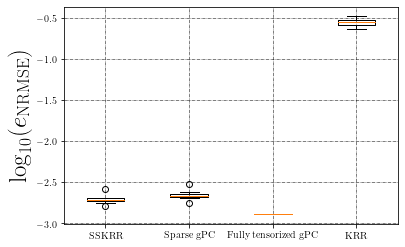

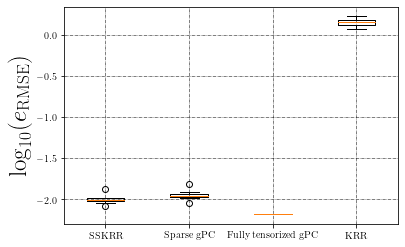

In [17]:
# Box plot
plt.figure()
plt.boxplot([np.log10(NRMSE_optm_list), np.log10(NRMSE_PCE_list), np.log10(NRMSE_FullT_list), np.log10(NRMSE_RBF_list)])
plt.xticks([1, 2, 3, 4], ["SSKRR", "Sparse gPC", "Fully tensorized gPC", "KRR"])
plt.grid(True, color = "black", which="major", ls="-.", linewidth = 0.5)
plt.ylabel(r"$\log_{10}(e_{\mathrm{NRMSE}})$")
plt.show()
plt.close()

plt.figure()
plt.boxplot([np.log10(RMSE_optm_list), np.log10(RMSE_PCE_list), np.log10(RMSE_FullT_list), np.log10(RMSE_RBF_list)])
plt.xticks([1, 2, 3, 4], ["SSKRR", "Sparse gPC", "Fully tensorized gPC", "KRR"])
plt.grid(True, color = "black", which="major", ls="-.", linewidth = 0.5)
plt.ylabel(r"$\log_{10}(e_{\mathrm{RMSE}})$")
plt.show()
plt.close()

### PDF

In [24]:
Y_TD_current = Y_TD_list[0]
Y_PCE_current = Y_PCE_TD_list[0]
Y_GPR_current = Y_GPR_list[0]
Y_FT_PCE_current = Y_FT_PCE_list[0]
Y_SSKRR_current = Y_SSKRR_TD_list[0]

# Ground Truth
GT_data = Y_TD_current
test_GT = np.linspace(np.min(GT_data), np.max(GT_data), num = int(1e5))
pdf_predict_GT = stats.gaussian_kde(GT_data)(test_GT)
pdf_predict_GT_sorted = np.sort(pdf_predict_GT)

# Sparse gPC
gPC_data = Y_PCE_current
pdf_predict_PCE = stats.gaussian_kde(gPC_data)(test_GT)
pdf_predict_PCE_sorted = np.sort(pdf_predict_PCE)

# SSKRR
optm_data = Y_SSKRR_current
pdf_predict_optm = stats.gaussian_kde(optm_data)(test_GT)
pdf_predict_optm_sorted = np.sort(pdf_predict_optm)

# KRR with Gaussian Kernel
RBF_data = Y_GPR_current
pdf_predict_RBF = stats.gaussian_kde(RBF_data)(test_GT)
pdf_predict_RBF_sorted = np.sort(pdf_predict_RBF)

# Full tensorized gPC
FullT_data = Y_FT_PCE_current
pdf_predict_FullT = stats.gaussian_kde(FullT_data)(test_GT)
pdf_predict_FullT_sorted = np.sort(pdf_predict_FullT)

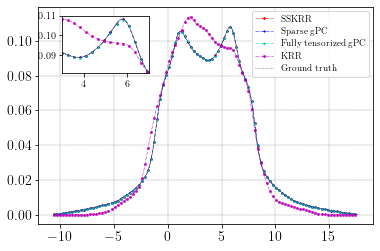

In [25]:
# Plot PDF
fig = plt.figure()
plt.plot(test_GT, pdf_predict_optm, 'rD-.', linewidth=0.5, alpha = 1, label = "SSKRR", markevery = 1000, markersize = 1.5)
plt.plot(test_GT, pdf_predict_PCE, 'b*-.', linewidth=0.5, alpha = 1, label = " Sparse gPC", markevery = 1000, markersize = 1.5)
plt.plot(test_GT, pdf_predict_FullT, 'c^-.', linewidth=0.5, alpha = 1, label = "Fully tensorized gPC", markevery = 1000, markersize = 1.5)
plt.plot(test_GT, pdf_predict_RBF, 'ms-.', linewidth=0.5, alpha = 1, label = "KRR", markevery = 1000, markersize = 1.5)
plt.plot(test_GT, pdf_predict_GT, 'k', linestyle = 'dotted', linewidth=0.5, alpha = 1, label = "Ground truth")
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.grid(True, color = "black", which="major", ls="-.", linewidth = 0.20)
plt.legend(fontsize = 9, loc="upper right")

# Create zoom-out plot
ax_new = fig.add_axes([0.18, 0.65, 0.2, 0.2]) # the position of zoom-out plot compare to the ratio of zoom-in plot
ax_new.plot(test_GT, pdf_predict_optm, 'rD-.', linewidth=0.5, alpha = 1, label = "SSKRR", markevery = 1000, markersize = 1.5)
ax_new.plot(test_GT, pdf_predict_PCE, 'b*-.', linewidth=0.5, alpha = 1, label = " Sparse gPC", markevery = 1000, markersize = 1.5)
ax_new.plot(test_GT, pdf_predict_FullT, 'c^-.', linewidth=0.5, alpha = 1, label = "Fully tensorized gPC", markevery = 1000, markersize = 1.5)
ax_new.plot(test_GT, pdf_predict_RBF, 'ms-.', linewidth=0.5, alpha = 1, label = "KRR", markevery = 1000, markersize = 1.5)
ax_new.plot(test_GT, pdf_predict_GT, 'k', linestyle = 'dotted', linewidth=0.5, alpha = 1, label = "Ground truth")
ax_new.set_xlim(3, 7)
ax_new.set_ylim(0.081, 0.11)
plt.show()

# Rosenbrock test function

## Rosenbrock function parameters

In [14]:
def FGT(_x):
    dimension = np.shape(_x)[1]
    rosenbrock = 0
    for d in range(dimension-1):
        rosenbrock = rosenbrock + (100*(_x[:, d+1] - _x[:, d]**2)**2 + (1-_x[:, d])**2)
    return rosenbrock

performance_func = "Rosenbroke_10D"

# Parameters of the study
number_of_seeds = 10
number_of_observations_LD_list = [400]

# Bounds of the input space
dimension = 10
bounds = np.zeros((dimension, 2))
bounds[:, 0], bounds[:, 1] = -2, 2
# Scaling the inputs
scaler = sklearn.preprocessing.MinMaxScaler((-1, 1))
scaler.fit(bounds.T)

MinMaxScaler(feature_range=(-1, 1))

## Surrogate modeling methods

### SSKRR Algorithm and sparse gPC

In [ ]:
# Some useful parameters
nuggets = 10**(np.linspace(np.log10(1e-12), np.log10(1e0), num = 31))

# Save the predictions on the test dataset
Y_SSKRR_TD_list = []
Y_PCE_TD_list = []
Y_TD_list = []

# Total order of the basis
total_order = 4

# Compute the corresponding indexes
indexes, _ = MultiIndex.MultiIndex(total_order, dimension)

# Corresponds to uniform distribution
alpha = [0]*dimension; beta = [0]*dimension

for number_of_observations_LD in number_of_observations_LD_list:
    for current_seed in range(number_of_seeds):
        print(f"Current seed: {current_seed}")
        seed = current_seed
        number_of_observations = number_of_observations_LD

        # Define the learning set
        # Number of observatitons of the learning set
        N_LD = number_of_observations

        # Sampling the learning set
        sampling = LHS_sampling(xlimits = bounds, criterion = "maximin", random_state = seed)
        X_LD = sampling(N_LD)
        X_LD_scaled = scaler.transform(X_LD)
        Y_LD = FGT(X_LD)

        _, dimension = np.shape(X_LD)
        kappa_var = np.var(Y_LD)

        # SPGL1 Optimization
        # min |c|_L1 s. t. ||Tc - b||_2 <= epsilon

        print(f"Compute theta for SPGL1 using PCE with total order {total_order} corresponding to {len(indexes)} expansion coefficients")
        theta = np.zeros((N_LD, len(indexes)))
        for obs in range(N_LD):
            theta[obs, :] = MPJacn.MPJacn(X_LD_scaled[obs, :], total_order, alpha, beta, indexes)

        # Convergence criterion for SPGL1
        sigma = 1e-6
        opt_tol = 1e-7

        # SPGL1 solver
        c, resid, grad, info = spgl1.spg_bpdn(theta, np.reshape(Y_LD, (-1,)), sigma, verbosity=3, iter_lim = int(1e5), opt_tol = opt_tol)

        # Plot the SPGL1 solution of the expansion coefficients
        plt.figure()
        plt.plot(abs(c), 'or', markersize=3, mec='k', mew = 0.5)
        plt.xlabel(r"i--th Legendre polynomial"); plt.ylabel(r"$|c_i|$")
        plt.grid(True, color = "black", which="major", ls="--", linewidth = 0.25)
        plt.grid(True, color = "gray", which="minor", ls="--", linewidth = 0.25)
        plt.show()
        plt.close('all')

        plt.figure()
        plt.plot(abs(c), 'or', markersize=3, mec='k', mew = 0.5)
        plt.yscale('log')
        plt.xlabel(r"i--th Legendre polynomial"); plt.ylabel(r"$|c_i|$")
        plt.grid(True, color = "black", which="major", ls="--", linewidth = 0.25)
        plt.grid(True, color = "gray", which="minor", ls="--", linewidth = 0.25)
        plt.show()
        plt.close('all')

        # c_k values and number of basis functions
        ck_value, R_S = c, np.shape(c)[0]

        # Matrix corresponding to the values of the basis at the observations
        e_sparse = theta

        # PCE
        # Norm for moment order of PCE
        norm_moment_order = 1
        for dim in range(dimension):
            norm_moment_order = norm_moment_order*(2**(alpha[dim]+beta[dim]+1)*factorial(alpha[dim])*factorial(beta[dim])/factorial(alpha[dim]+beta[dim]+1))
        norm_moment_order = np.sqrt(norm_moment_order)

        # Mean using PCE
        mean_PCE = ck_value[0] / norm_moment_order
        # Variance using PCE
        var_PCE = np.sum(ck_value[1:]**2) / norm_moment_order**2

        # SSKRR Algorithm
        # Minimize the eigenvalues
        sigma_min = []
        for k in range(R_S):
            num = np.abs(ck_value[k])
            den = np.sum(np.abs(ck_value))
            sigma_temp = kappa_var*(num/den)
            sigma_min.append(sigma_temp)

        sigma_min = np.array(sigma_min).reshape((-1,))

        # Test dataset
        # Compute the error over test_sampling using N_TD sampling
        N_TD = int(1e5)
        np.random.seed(seed)
        X_TD_scaled = np.random.uniform(-1, 1, size=(N_TD, dimension))
        X_TD = scaler.inverse_transform(X_TD_scaled)
        Y_TD = FGT(X_TD)
        Y_TD_list.append(Y_TD)

        # Compute PCE in the test dataset
        e_PCE = np.zeros((N_TD, R_S))
        for idx in range(R_S):
            e_PCE[:, idx] = ProdLegendrePoly(X_TD_scaled, indexes[idx]).reshape((-1, ))
        Y_PCE = e_PCE @ np.array(ck_value)
        Y_PCE_TD_list.append(Y_PCE)

        RMSE_gPC = np.sqrt(np.mean((Y_PCE - Y_TD)**2))

        # Find the best value of the nugget through grid search
        RMSE_optm_list = []
        for nugget in nuggets:
            # Prediction mean of the GP using the kernel given by the SSKRR algorithm
            K_OBS = e_sparse @ np.diag(sigma_min) @ e_sparse.T
            K_OBS = K_OBS + nugget*np.eye(N_LD)
            K_PREDICT = e_PCE @ np.diag(sigma_min) @ e_sparse.T
            Y_predict_optm = K_PREDICT @ np.linalg.solve(K_OBS, Y_LD)

            # Save the current RMSE on the test set
            RMSE_optm_list.append(np.sqrt(np.mean((Y_TD - Y_predict_optm)**2)))

            # Only keep the best kernel
            if (len(RMSE_optm_list) == 1) or (RMSE_optm_list[-1] < np.min(RMSE_optm_list[:-1])):
                # Value of the minimum of the RMSE
                min_RMSE_SSKRR = RMSE_optm_list[-1]

                # Kappa corresponding to the minimum of the RMSE
                min_nugget = nugget

                # Best prediction corresponding to the minimum of the RMSE
                Y_best_predict_optm = Y_predict_optm

        Y_SSKRR_TD_list.append(Y_best_predict_optm)

        print(f"Log10(RMSE) with SSKRR algorithm: {np.log10(min_RMSE_SSKRR)}")
        print(f"Log10(RMSE) with gPC: {np.log10(RMSE_gPC)}")

### Gaussian process regression with Gaussian kernel

In [ ]:
init_nugget_kernel = 0
Y_GPR_list = []
for number_of_observations_LD in number_of_observations_LD_list:
    for current_seed in range(number_of_seeds):
        # Current seed for LHS
        seed = current_seed

        # Define the learning set
        # Number of observatitons of the learning set
        N_LD = number_of_observations_LD

        # Sampling the learning set
        sampling = LHS_sampling(xlimits = bounds, criterion = "maximin", random_state = seed)
        X_LD = sampling(N_LD)
        X_LD_scaled = scaler.transform(X_LD)
        Y_LD = FGT(X_LD)

        _, dimension = np.shape(X_LD)
        kappa_var = np.var(Y_LD)
        # Test dataset
        # Compute the error over test_sampling using N_TD sampling
        N_TD = int(1e5)
        np.random.seed(seed)
        X_TD_scaled = np.random.uniform(-1, 1, size=(N_TD, dimension))
        X_TD = scaler.inverse_transform(X_TD_scaled)
        Y_TD = FGT(X_TD)

        # Initial lengthscale
        # One lengthscale per input dimension
        gamma = []
        for d in range(dimension):
            temp = krr_helpers.compute_RMS_from_data(X_LD_scaled[:, d])/np.sqrt(2)
            gamma.append(temp)

        # GPR using pytorch
        Nf, Nc = (N_LD, int(N_LD/2))
        ite_max = int(10000)
        ite_save = int(100)

        # Pif and Pic
        Pif, Pic = krr_helpers.create_pif_pic(N_LD, Nf, Nc, seed = None)

        # Parameters of the algo
        variable_gamma = torch.tensor(gamma, requires_grad=True)
        nugget_optm = torch.tensor([init_nugget_kernel], requires_grad=False)
        nugget_optm_list = []
        nugget_optm_list.append(torch.clone(nugget_optm).detach().numpy())
        variable_gamma_optm = [torch.clone(variable_gamma).detach().numpy()]

        # Choice of the kernel
        kernel = gp.kernels.RBF(input_dim = dimension, variance=torch.tensor(1.), lengthscale=variable_gamma) # RBF

        # Compute the loss and choose the optimizer
        loss = compute_ρ_torch_pyro(torch.from_numpy(X_LD_scaled), torch.tensor(Y_LD), Pif, Pic, nugget_optm, kernel)
        optimizer = torch.optim.Adam([kernel.lengthscale_unconstrained, nugget_optm], lr = 3e-4)

        # Clear pyro parameters for new loop
        pyro.clear_param_store()

        # GPR Prediction
        gpr_opt = gp.models.GPRegression(torch.from_numpy(X_LD_scaled), torch.from_numpy(Y_LD), kernel, noise=torch.tensor(0.), jitter = nugget_optm)
        value_torch, _ = gpr_opt(torch.from_numpy(X_TD_scaled), full_cov=False, noiseless=True)
        value_torch = torch.clone(value_torch).detach().numpy()
        RMSE_torch = np.sqrt(np.mean((Y_TD - value_torch)**2))
        ρ_optm = [loss]
        print(f"ρ_optm: {ρ_optm}")
        ite_list = [0]
        RMSE_torch_list_temp = [RMSE_torch]
        for k in range(ite_max):
            optimizer.zero_grad()
            loss = compute_ρ_torch_pyro(torch.from_numpy(X_LD_scaled), torch.tensor(Y_LD), Pif, Pic, nugget_optm, kernel)
            loss.backward()
            optimizer.step()
            with torch.no_grad():
                kernel.lengthscale[:] = kernel.lengthscale.clamp(0, 1e6)
                nugget_optm[:] = nugget_optm.clamp(0, 1e6)
                if (k+1)%ite_save == 0:
                    print(f"Learning: Iteration n. {k+1} / {ite_max}")

                    # Print current length scales of the kernel
                    print(kernel.lengthscale)

                    # Store loss value and current optimized parameters
                    ρ_optm.append(loss.item())
                    ite_list.append((k+1))
                    variable_gamma_optm.append(torch.clone(kernel.lengthscale).detach().numpy())
                    nugget_optm_list.append(torch.clone(nugget_optm).detach().numpy())

                    # Compute the test error
                    gpr_opt = gp.models.GPRegression(torch.from_numpy(X_LD_scaled), torch.from_numpy(Y_LD), kernel, noise=torch.tensor(0.), jitter = nugget_optm)
                    value_torch, _ = gpr_opt(torch.from_numpy(X_TD_scaled), full_cov=False, noiseless=True)
                    value_torch = torch.clone(value_torch).detach().numpy()
                    RMSE_torch = np.sqrt(np.mean((Y_TD - value_torch)**2))
                    RMSE_torch_list_temp.append(RMSE_torch)

            # Update new batch
            Pif, Pic = krr_helpers.create_pif_pic(N_LD, Nf, Nc, seed = None)

        plt.figure()
        plt.plot(ite_list, RMSE_torch_list_temp, '-ok', markersize = 4, markeredgecolor = 'r', markeredgewidth = 1)
        plt.yscale("log")
        plt.xlabel(r"Number of iterations")
        plt.ylabel(r"$\log_{10}(e_{RMSE})$")
        plt.show()
        plt.close('all')

        plt.figure()
        plt.plot(ite_list, ρ_optm, '-ok', markersize = 4, markeredgecolor = 'r', markeredgewidth = 1)
        plt.yscale("log")
        plt.xlabel(r"Number of iterations")
        plt.ylabel(r"$\rho$")
        plt.show()
        plt.close('all')

        plt.figure()
        plt.plot(ite_list, nugget_optm_list, '-ok', markersize = 4, markeredgecolor = 'r', markeredgewidth = 1)
        plt.yscale("log")
        plt.xlabel(r"Number of iterations")
        plt.ylabel(r"$\lambda$")
        plt.show()
        plt.close('all')

        # Compute with the best hyperparameters on the test set
        idx_min_RMSE = np.argmin(RMSE_torch_list_temp)
        gamma_min = variable_gamma_optm[idx_min_RMSE]
        kernel_best = gp.kernels.RBF(input_dim = dimension, variance=torch.tensor(1.), lengthscale=torch.from_numpy(gamma_min)) # RBF
        gpr_opt_best = gp.models.GPRegression(torch.from_numpy(X_LD_scaled), torch.from_numpy(Y_LD), kernel_best, noise=torch.tensor(0.), jitter = nugget_optm)
        value_torch_best, _ = gpr_opt_best(torch.from_numpy(X_TD_scaled), full_cov=False, noiseless=True)
        value_torch_best = torch.clone(value_torch_best).detach().numpy()

        Y_GPR_list.append(value_torch_best)

        print(f"Log10(RMSE): {np.log10(RMSE_torch_list_temp[idx_min_RMSE])}")

## Post-processing

### Box-plot

In [ ]:
NRMSE_optm_list, RMSE_optm_list = [], []
NRMSE_PCE_list, RMSE_PCE_list = [], []
NRMSE_RBF_list, RMSE_RBF_list, = [], []

for k in range(number_of_seeds):
        Y_TD_current = Y_TD_list[k]
        Y_PCE_current = Y_PCE_TD_list[k]
        Y_GPR_current = Y_GPR_list[k]
        Y_SSKRR_current = Y_SSKRR_TD_list[k]

        # Prediction coefficient
        Q2_PCE_list.append(1 - np.sum((Y_TD_current - Y_PCE_current)**2) / np.sum((Y_TD_current - np.mean(Y_TD_current))**2))
        Q2_optm_list.append(1 - np.sum((Y_TD_current - Y_SSKRR_current)**2) / np.sum((Y_TD_current - np.mean(Y_TD_current))**2))
        Q2_RBF_list.append(1 - np.sum((Y_TD_current - Y_GPR_current)**2) / np.sum((Y_TD_current - np.mean(Y_TD_current))**2))

        # NRMSE
        NRMSE_PCE_list.append(np.sqrt(np.sum((Y_TD_current - Y_PCE_current)**2) / np.sum((Y_TD_current)**2)))
        NRMSE_optm_list.append(np.sqrt(np.sum((Y_TD_current - Y_SSKRR_current)**2) / np.sum((Y_TD_current)**2)))
        NRMSE_RBF_list.append(np.sqrt(np.sum((Y_TD_current - Y_GPR_current)**2) / np.sum((Y_TD_current)**2)))

        # RMSE
        RMSE_PCE_list.append(np.sqrt(np.mean((Y_TD_current - Y_PCE_current)**2)))
        RMSE_optm_list.append(np.sqrt(np.mean((Y_TD_current - Y_SSKRR_current)**2)))
        RMSE_RBF_list.append(np.sqrt(np.mean((Y_TD_current - Y_GPR_current)**2)))

        # Max Error Rel
        MAX_ERROR_PCE_list.append(np.max(np.abs((Y_TD_current - Y_PCE_current) / (Y_TD_current)))*100)
        MAX_ERROR_optm_list.append(np.max(np.abs((Y_TD_current - Y_PCE_current) / (Y_TD_current)))*100)
        MAX_ERROR_RBF_list.append(np.max(np.abs((Y_TD_current - Y_GPR_current) / (Y_TD_current)))*100)

### PDF

In [ ]:
Y_TD_current = Y_TD_list[0]
Y_PCE_current = Y_PCE_TD_list[0]
Y_GPR_current = Y_GPR_list[0]
Y_SSKRR_current = Y_SSKRR_TD_list[0]

# Ground Truth
GT_data = Y_TD_current
test_GT = np.linspace(np.min(GT_data), np.max(GT_data), num = int(1e5))
pdf_predict_GT = stats.gaussian_kde(GT_data)(test_GT)
pdf_predict_GT_sorted = np.sort(pdf_predict_GT)

# Sparse gPC
gPC_data = Y_PCE_current
pdf_predict_PCE = stats.gaussian_kde(gPC_data)(test_GT)
pdf_predict_PCE_sorted = np.sort(pdf_predict_PCE)

# SSKRR
optm_data = Y_SSKRR_current
pdf_predict_optm = stats.gaussian_kde(optm_data)(test_GT)
pdf_predict_optm_sorted = np.sort(pdf_predict_optm)

# KRR with Gaussian Kernel
RBF_data = Y_GPR_current
pdf_predict_RBF = stats.gaussian_kde(RBF_data)(test_GT)
pdf_predict_RBF_sorted = np.sort(pdf_predict_RBF)

# Full tensorized gPC
FullT_data = Y_FT_PCE_current
pdf_predict_FullT = stats.gaussian_kde(FullT_data)(test_GT)
pdf_predict_FullT_sorted = np.sort(pdf_predict_FullT)